<a href="https://colab.research.google.com/github/jinwoo95/Seq2Seq-Modelling-Study/blob/main/Week3.Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#공유 드라이브 연결
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
os.chdir('gdrive/MyDrive/DoVie/Week2 Attention/')

Mounted at /content/gdrive/


참고자료 : https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html

## Attention이 나온 배경

- 앞에서 배운 Encoder-Decoder 모델에서 Encoder는 input을 요약하여 하나의 vector로 출력하고, Decoder는 출력된 Vector를 계속해서 input으로 사용합니다. 하지만 이러한 메커니즘에서는 하나의 고정된 크기의 vector에 input을 구겨 넣어야 하므로, input 크기가 길어질수록 정보 손실이 발생할 수 밖에 없습니다.
- 그리고 RNN의 고질적은 문제인 기울기 소실 문제가 존재합니다.
- 이러한 문제를 해결하고자 나온 것이 Attention 입니다.

## Attention 기본 아이디어

- 어텐션은 디코더에서 단어를 출력하는 매 시점에 한번씩 인코더에서 입력된 전체 문장을 검토합니다. 하지만 인코더에 입력된 전체 인풋을 똑같은 중요도의 비율로 검토하는 것이 아니라, 특정 단어에 집중(Attention)하여 입력된 문장을 검토합니다.

- Attention value를 통해 해당 시점에서 어떤 단어가 중요한지 판단을 해주고, Attention value, input, prev_hidden 값이 인풋으로 Decoder에 들어가게 됩니다.

- 아래의 예제를 보면서 어텐션을 이해해 봅시다.
- 바다나우 어텐션을 이용하여 예제를 구성했습니다.

## Attention Value
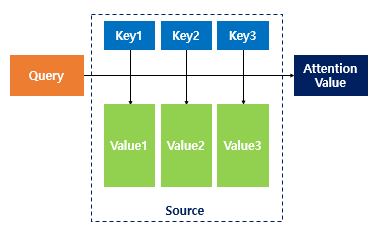


- 어텐션을 함수로 표현하면 주로 다음과 같이 표현됩니다.

- Attention(Q, K, V) = Attention Value




- Q = Query : t-1 시점의 디코더 셀에서의 은닉 상태
- K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
- V = Values : 모든 시점의 인코더 셀의 은닉 상태들

- Attention Value를 어떻게 구하는지 예제를 통해 알아봅시다.

### 패키지 load

In [ ]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Attention value Process
#### 1. Attention Score를 구한다.

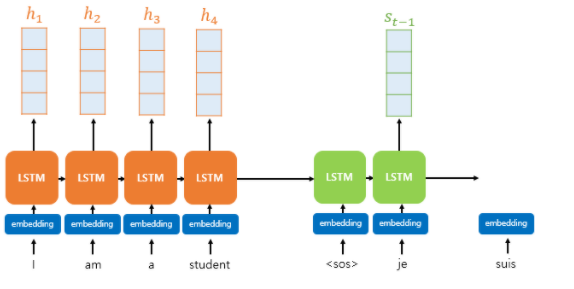

- 인코더의 은닉상태를 각각 h1,h2,..,hn이라고 하고, 디코더의 현재 시점 t에서의 은닉상태를 s_t라고 합시다. 루옹 어텐션에서는 디코더의 t시점의 은닉상태를 사용했지만, 바다나우 어텐션에서는 s_{t-1}과 인코더의 i번째 은닉 상태의 어텐션 스코어를 사용합니다.

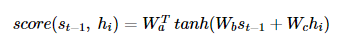
- W_a,W_b,W_c는 학습 가능한 가중치 행렬이며, h_i는 각 시점의 인코더의 출력 값이 모여있는 matrix입니다.
- 그림을 통해 이해해봅시다.

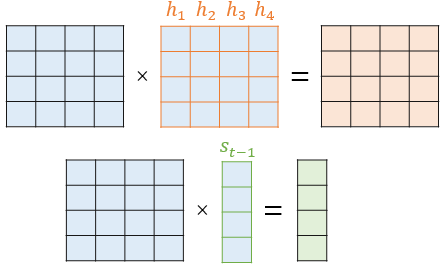

- 이들을 더한 후, 하이퍼볼릭탄젠트 함수를 지나도록 합니다. 

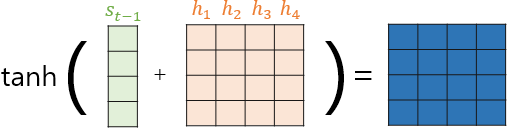

- 지금까지 진행된 연산의 수식은 
- tanh(W_bs_{t−1}+W_c*h_i)

- 이제 W_a.T와 곱하여 s_{t−1}와 h1,h2,h3,h4의 유사도가 기록된 어텐션 스코어 벡터 e_t를 얻습니다.

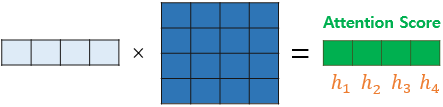

- e_t=W_a.T * tanh(W_b*s_{t−1}+W_c*h_i)

In [ ]:
#seed 고정
torch.manual_seed(5)

#Encoder_output과 Decoder_h값 정의
enco_h = torch.rand(4,4)
deco_h = torch.rand(4)

#hidden_size 정의
hidden_size = 4

#Linear layer 정의하기. // concat해야하기 때문에 hiddne_size * 2 이다.
layer1 = nn.Linear( hidden_size * 2 , 4)

#output 형식 정의. //앞 부분은 sequence의 길이라고 생각하면 된다.
output = torch.zeros(hidden_size, hidden_size)

#Linear 계층 통과 후, 하이퍼볼릭 탄젠트함수 거치기.
for i in range(4) :
  output[i] = torch.tanh(layer1(torch.cat((enco_h[i],deco_h),0)))

#W_a.T정의하기.
v = nn.Parameter(torch.rand(1,hidden_size))

#Attention Score 구하기.
Score = torch.mm(v,output)
Score

tensor([[ 0.1289, -1.3522,  0.9899,  1.4909]], grad_fn=<MmBackward>)

In [ ]:
v * output[:,0]

tensor([[ 0.1098,  0.0642, -0.0142, -0.0309]], grad_fn=<MulBackward0>)

In [ ]:
output

tensor([[ 0.1343, -0.6788,  0.6601,  0.7186],
        [ 0.3560, -0.5730,  0.6804,  0.6047],
        [-0.0606, -0.5697,  0.1818,  0.6806],
        [-0.0318, -0.5756,  0.2924,  0.6521]], grad_fn=<CopySlices>)

In [ ]:
output[:,0]

tensor([ 0.1343,  0.3560, -0.0606, -0.0318], grad_fn=<SelectBackward>)

In [ ]:
enco_h , deco_h

(tensor([[0.8303, 0.1261, 0.9075, 0.8199],
         [0.9201, 0.1166, 0.1644, 0.7379],
         [0.0333, 0.9942, 0.6064, 0.5646],
         [0.0724, 0.6593, 0.7150, 0.5793]]),
 tensor([0.9809, 0.6502, 0.0566, 0.9201]))

In [ ]:
torch.cat((enco_h[0],deco_h),0)

tensor([0.8303, 0.1261, 0.9075, 0.8199, 0.9809, 0.6502, 0.0566, 0.9201])

In [ ]:
output

tensor([[ 0.1343, -0.6788,  0.6601,  0.7186],
        [ 0.3560, -0.5730,  0.6804,  0.6047],
        [-0.0606, -0.5697,  0.1818,  0.6806],
        [-0.0318, -0.5756,  0.2924,  0.6521]], grad_fn=<CopySlices>)

In [ ]:
torch.tanh(output[1])

tensor([ 0.3417, -0.5175,  0.5918,  0.5404], grad_fn=<TanhBackward>)

In [ ]:
#W_a.T정의하기.
v = nn.Parameter(torch.FloatTensor(hidden_size))
v

Parameter containing:
tensor([1.8248e+06, 3.0910e-41, 5.0447e-44, 0.0000e+00], requires_grad=True)

### Attention Score process
#### 2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.

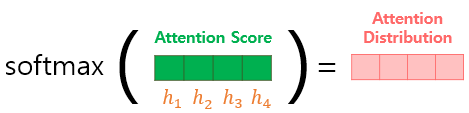

- e_t에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 어텐션 분포(Attention Distribution)라고 하며, 각각의 값은 어텐션 가중치(Attention Weight)라고 합니다.

In [ ]:
A_D = F.softmax(Score)
A_D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.1334, 0.0303, 0.3155, 0.5208]], grad_fn=<SoftmaxBackward>)

### Attention Score Process
#### 3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.
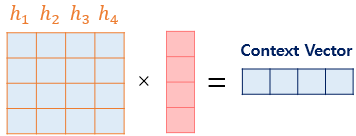


이제 지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 가중합(Weighted Sum)을 한다고 말할 수도 있겠습니다. 이 벡터는 인코더의 문맥을 포함하고 있다고하여, 컨텍스트 벡터(context vector)라고 부릅니다.

In [ ]:
context = torch.mm(enco_h,A_D.T)
context

tensor([[0.8279],
        [0.5624],
        [0.5199],
        [0.5569]], grad_fn=<MmBackward>)

In [ ]:
context = context.T
context

tensor([[0.8279, 0.5624, 0.5199, 0.5569]], grad_fn=<PermuteBackward>)

### Attention value process
#### 4) 컨텍스트 벡터로부터 st를 구합니다.
- 기존의 LSTM이 s_t를 구할 때를 아래 그림을 통해 상기해봅시다. 기존의 LSTM은 이전 시점의 셀로부터 전달받은 은닉 상태 s_{t−1}와 현재 시점의 입력 xt를 가지고 연산하였습니다. 아래의 LSTM은 seq2seq의 디코더이며 현재 시점의 입력 x_t는 임베딩된 단어 벡터입니다.

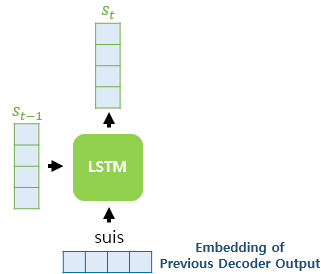


그렇다면 어텐션 메커니즘에서는 어떨까요? 아래의 그림은 바다나우 어텐션 메커니즘에서는 컨텍스트 벡터와 현재 시점의 입력인 단어의 임베딩 벡터를 연결(concatenate)하고, 현재 시점의 새로운 입력으로 사용하는 모습을 보여줍니다. 그리고 이전 시점의 셀로부터 전달받은 은닉 상태 s_{t−1}와 현재 시점의 새로운 입력으로부터 s_t를 구합니다.

다시 말해 기존의 LSTM이 임베딩된 단어 벡터를 입력으로 하는 것에서 컨텍스트 벡터와 임베딩된 단어 벡터를 연결(concatenate)하여 입력으로 사용하는 것이 달라졌습니다.

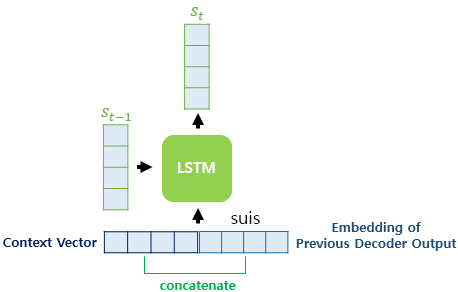

이후에는 어텐션 메커니즘을 사용하지 않는 경우와 동일합니다. s_t는 출력층으로 전달되어 현재 시점의 예측값을 구하게 됩니다. 



In [ ]:
#context = context.squeeze(0)
context 

tensor([[0.8279, 0.5624, 0.5199, 0.5569]], grad_fn=<PermuteBackward>)

In [ ]:
input = torch.rand(1,4)

#fi_input = torch.cat((context,input),1)

In [ ]:
fi_input.size()

torch.Size([1, 8])

In [ ]:
hidden = torch.rand(1,1,4)
hidden.size()

torch.Size([1, 1, 4])

In [ ]:
lstm = nn.LSTM(hidden_size * 2, hidden_size) #input과 output size를 넣어줍니다.



In [ ]:
lstm = nn.LSTM(hidden_size * 2, hidden_size) #input과 output size를 넣어줍니다.

input = torch.rand(1,4)

fi_input = torch.cat((context,input),1).unsqueeze(0)

#context = context.unsqueeze(0)
#lstm의 인풋으로 넣기 위한 차원 조정.
deco_h = deco_h.unsqueeze(0).unsqueeze(0)
#왜 Error가 뜨는 것일까?
_ , s_t = lstm(fi_input,(hidden,hidden))
s_t

(tensor([[[ 0.1576, -0.0465, -0.0566,  0.3421]]], grad_fn=<StackBackward>),
 tensor([[[ 0.6426, -0.2472, -0.3934,  0.5719]]], grad_fn=<StackBackward>))

In [ ]:
fi_input.size()

torch.Size([1, 1, 8])

In [ ]:
#deco_h = deco_h.unsqueeze(0)
deco_h = deco_h.squeeze(0)
deco_h

tensor([0.9809, 0.6502, 0.0566, 0.9201])

In [ ]:
deco_h.size(3)

4

In [ ]:
temp

tensor([0.8279, 0.5624, 0.5199, 0.5569, 0.7490, 0.1319, 0.5845, 0.2099],
       grad_fn=<CatBackward>)

In [ ]:

temp

torch.Size([8])

In [ ]:
deco_h.size()

torch.Size([4])

In [ ]:
context.squeeze()

tensor([0.8279, 0.5624, 0.5199, 0.5569], grad_fn=<SqueezeBackward0>)

### batch_size로 나뉘어져있는 데이터로 학습해보기
- 실제 학습을 진행할 때는 batch_size만큼 데이터를 보고 학습하며, 이를 실습으로 진행하고 LSTM셀까지 넣어보는 과정을 진행해보겠습니다.

In [ ]:
#seed 고정
import torch
torch.manual_seed(5)

batch_size, seq_len, hidden_size = 256, 10 , 4  #batch_size는 256, sequence의 길이는 10, hidden_size는 4입니다.

hs = torch.rand(batch_size, seq_len, hidden_size)  #encoder의 output들이 모여있는 변수.
prev_hidden = torch.rand(batch_size, hidden_size) #t시점에서의 Decoder의 hidden_state입니다.

#Linear layer 정의하기. // concat해야하기 때문에 hiddne_size * 2 이다.
layer1 = nn.Linear(hidden_size * 2 , 4)

#output 형식 정의. //앞 부분은 sequence의 길이라고 생각하면 된다.
score = Variable(torch.zeros(batch_size, seq_len))

#a_v 정의.
attv = Variable(torch.zeros(batch_size,hidden_size)) 

#attention_energies 정의하기
attn_energies = Variable(torch.zeros(batch_size, seq_len, hidden_size))
#Linear 계층 통과 후 사용될 파라미터 정의
#W_a.T정의하기.
v = nn.Parameter(torch.FloatTensor(1,hidden_size))

#Linear 계층 통과 후, 하이퍼볼릭 탄젠트함수 거치기.
for b in range(batch_size):
  #데이터 한개씩. 꺼내오기. batch와 해당 sequence 길이 만큼 반복문.  
  for i in range(seq_len) :   
    attn_energies[b,i] = torch.tanh(layer1(torch.cat((hs[b,i],prev_hidden[b,:]),0)))
    
  score[b] = F.softmax(torch.mm(attn_energies[b,:],v.T).T)
  attv[b] = score[b].unsqueeze(0).mm(hs[b,:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
attv

tensor([[0.2639, 0.3906, 0.1661, 0.2636],
        [0.2225, 0.2148, 0.3662, 0.3384],
        [0.3386, 0.0416, 0.1424, 0.1164],
        ...,
        [0.6812, 0.2256, 0.0808, 0.1267],
        [0.0898, 0.3006, 0.4058, 0.9981],
        [0.3425, 0.0658, 0.0094, 0.8851]], grad_fn=<CopySlices>)

In [ ]:
score[b].unsqueeze(0).size()

torch.Size([1, 10])

In [ ]:
torch.mm(attn_energies[b,:],v.T)

tensor([[-1.2138e+31],
        [-8.7185e+30],
        [-1.2118e+31],
        [-1.0631e+31],
        [-1.2316e+31],
        [-7.7465e+30],
        [-1.0655e+31],
        [-6.5456e+30],
        [-9.8622e+30],
        [-1.0254e+31]], grad_fn=<MmBackward>)

In [ ]:
a = torch.rand(2,1,3)
a = a[1,:]
a

tensor([[0.3545, 0.1896, 0.7584]])

In [ ]:
F.softmax(a)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.2989, 0.2535, 0.4477]])

In [ ]:
hs[1,].size()

torch.Size([10, 4])

In [ ]:
F.softmax(a[1,])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0.2305, 0.3009, 0.4686])

In [ ]:
v.T.size()

torch.Size([4, 10])

In [ ]:
attn_energies[1,:].size()

torch.Size([10, 4])

In [ ]:
v.T.mm(attn_energies[1,:])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<MmBackward>)

In [ ]:
a = torch.rand(2,3)
b = torch.rand(2,3)

torch.mm(a,b.T)

tensor([[0.7099, 0.5763],
        [0.3664, 0.8892]])

In [ ]:
a , b

(tensor([[0.7211, 0.2256, 0.5761],
         [0.1601, 0.0423, 0.6094]]), tensor([[0.5471, 0.7650, 0.2371],
         [0.9016, 0.2952, 0.8641]]))

In [ ]:
torch.manual_seed(5)

batch_size, seq_len, hidden_size = 256, 10 , 4  #batch_size는 256, sequence의 길이는 10, hidden_size는 4입니다.

hs = torch.rand(2,seq_len, hidden_size)
hs

tensor([[[0.8303, 0.1261, 0.9075, 0.8199],
         [0.9201, 0.1166, 0.1644, 0.7379],
         [0.0333, 0.9942, 0.6064, 0.5646],
         [0.0724, 0.6593, 0.7150, 0.5793],
         [0.9809, 0.6502, 0.0566, 0.9201],
         [0.6698, 0.2615, 0.0407, 0.7850],
         [0.9752, 0.0903, 0.5273, 0.6794],
         [0.2639, 0.3906, 0.1661, 0.2636],
         [0.0442, 0.4884, 0.7965, 0.7432],
         [0.9697, 0.0609, 0.4385, 0.9868]],

        [[0.5819, 0.3590, 0.0497, 0.7327],
         [0.8796, 0.9009, 0.9186, 0.5979],
         [0.8564, 0.3741, 0.9061, 0.4572],
         [0.3969, 0.2515, 0.7662, 0.7023],
         [0.8180, 0.1805, 0.2342, 0.9732],
         [0.2225, 0.2148, 0.3662, 0.3384],
         [0.1600, 0.9041, 0.5557, 0.7280],
         [0.8709, 0.1760, 0.8817, 0.2495],
         [0.4204, 0.8784, 0.9610, 0.9389],
         [0.7876, 0.9647, 0.3198, 0.4682]]])

In [ ]:
hs[0,0]

tensor([0.8303, 0.1261, 0.9075, 0.8199])

In [ ]:
prev_hidden = torch.rand(batch_size, hidden_size)
prev_hidden[2,:]

tensor([0.2218, 0.3139, 0.3856, 0.1039])

In [ ]:
temp = torch.tanh(layer1(torch.cat((hs[0,1],prev_hidden[1,:]),0)))

In [ ]:
temp.T.size()

torch.Size([4])

In [ ]:
v = nn.Parameter(torch.rand(batch_size,seq_len,hidden_size))
v[0,1]

tensor([0.2125, 0.0455, 0.7436, 0.7145], grad_fn=<SelectBackward>)

In [ ]:
v[0,1].T * temp

tensor([ 0.0815, -0.0265,  0.4610,  0.4651], grad_fn=<MulBackward0>)

In [ ]:
v[0,1] * temp

tensor([ 0.0815, -0.0265,  0.4610,  0.4651], grad_fn=<MulBackward0>)

In [ ]:
output = Variable(torch.zeros(batch_size, seq_len))
output.size()

torch.Size([256, 10])

### 데이터 파일 로딩
- 해당 데이터트 수천 개의 영어-프랑스어 번역 쌍입니다.
- 번역에는 아주 많은 단어들이 있기 때문에 인코딩 벡터 크기가 매우 큽니다. 그래서 해당 예제에서는 약간의 트릭을 써서 데이터에서 등장한 단어만 사용하여 embeding 하도록 데이터를 다듬었습니다.

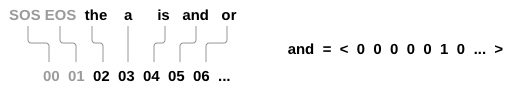

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가 필요합니다. 이 모든 것을 추적하기 위해 우리는 단어→색인(word2index)과 색인→단어(index2word) 사전, 그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도 word2count 를 가진 Lang 이라는 헬퍼 클래스를 사용합니다.

### Lang Class

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

파일은 모두 유니 코드로 되어있어 간단하게하기 위해 유니 코드 문자를 ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을 지워줍니다.


In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.



In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

많은 예제 문장이 있고 신속하게 학습하기를 원하기 때문에 비교적 짧고 간단한 문장으로만 데이터 셋을 정리할 것입니다. 여기서 최대 길이는 10 단어 (종료 문장 부호 포함)이며 “I am” 또는 “He is” 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에 아포스트로피는 대체 됨)

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

데이터 준비를 위한 전체 과정:

- 텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.

- 텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.

- 쌍을 이룬 문장들로 단어 리스트를 생성합니다.

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['vous etes deloyaux .', 'you re disloyal .']


## 인코더

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

### 전체적인 과정 요약
- t시점에 특정 단어가 input으로 들어오면 embedding을 통해 해당 단어를 벡터로 표시하고, 해당 값과 t-1시점의 hidden state 출력 값을 GRU 셀에 인풋으로 넣는다.
- GRU 셀의 출력은 두 가지 이용되는데 하나는 다음 Hidden state 셀에 입력이 되고, 나머지 하나는 output list에 삽입된다. 

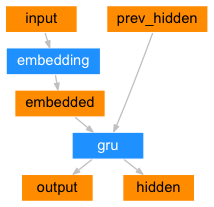

#### ____init____ function
- 해당 function은 class가 생성될 때 구조를 정의해주는 기능을 한다. 
- nn.module을 상속받고, RNN구조를 설정해주는데, hidden_size 설정을 통해서 hidden cell의 output의 size를 설정해준다. 
- 그리고 embedding 클래스를 호출하여, input_size의 input_data를 받으면 hidden_size의 vector로 embedding한다.
- 마지막으로 Hidden cell은 연산속도가 비교적 빠른 GRU cell을 이용하며, input(embedding을 거쳤으므로)과 hidden_state 모두 크기가 hidden_size기이 때문에, 두 개의 인풋 사이즈가 hidden_size로 동일하다.

#### foward function
- 해당 function은 데이터가 output으로 나오기까지의 과정을 보여주는 함수이다.
- 처음 input_data는 embedding 과정을 거치는데, (1,1,-1)은 sequence = 1, batch_size = 1, input_size 만 n인 것으로 해석가능하며, 한 문장이 잘려서 들어오는 것이 아닌, 통째로 하나의 vector로 들어가고 있음을 확인할 수 있다. 
- embedding함수를 통해 나온 값을 gru 셀에 넣어준다. 그리고 gru의 출력 값을 return 받는다.

#### initHidden function
- 해당 함수는 첫 hidden_state 를 0으로 만들어주는 함수이다.



In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__() ##nn.Module 상속.
        
        self.hidden_size = hidden_size #Hidden size는 Hidden cell의 유닛 개수.

        self.embedding = nn.Embedding(input_size, hidden_size) #input을 embedding하는 함수.input은 hidden size 크기로 embedding된다.

        self.gru = nn.GRU(hidden_size, hidden_size) #input이 embedding되면 hidden_size가 되기 때문에 hiddensize가 input이 된다. 

    def forward(self, input, hidden):

        embedded = self.embedding(input).view(1, 1, -1) #input을 embedding 및 차원 변경. 1개의 sequence == Hidden cell의 개수, 1개의 row(batch_size), n개의 column

        output = embedded  #output은 embedding된 하나의 input sequence임.(hidden_size와 같다)

        output, hidden = self.gru(output, hidden) #GRU에서 input은 input sequence와 hidden state 출력 값 2개가 된다.

        return output, hidden

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device) ##1개의 sequence == Hidden cell의 개수, 1개의 row, n개의 column

### 근본 Attention Decoder

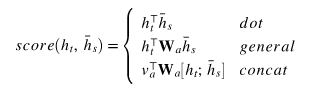

- Bahdanau Attention을 활용하여 짜볼것이고, Concat 기법으로 Score를 구해보겠습니다. 
- Attention Class는 Attention Score를 계산하는 함수와 Score를 계산한 후, Softmax를 통해 Attention distribution를 추출하여 attn_energies에 쌓는 역할을 한다. 
- 그리고 나중에 Bahdanau Attention Decoder에서는 쌓여있는 attn_energies 들을 context_vector로 그때그때 변환하는 Class를 구현한다.

In [ ]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
      super(Attn, self).__init__()
      
      self.method = method
      self.hidden_size = hidden_size

      #concat 방식으로 개발해보겠다. Score를 구하기 위해서 필요한 구조들을 정의한다.
      self.attn = nn.Linear(self.hidden_size * 2, hidden_size) #encoder_output과 Decoder의 Hidden State이 인풋으로 들어온다. encoder_output의 size가 hiddens_size인 이유는 특정 시점에서의 하나의 output이기 때문이다.  
      self.v = nn.Parameter(torch.FloatTensor(hidden_size)) #Hidden size개수 만큼 parameter 생성.(random하게 일단)

    #기본적인 attention구조에서 어떻게 학습되는가?
    def forward(self, hidden, encoder_outputs):
      #encoder_outputs은 S(Sequence의 길이) , Batch_size(batch_size), embedding_size(해당 단어의 임베딩 vector)
      max_len = encoder_outputs.size(0) #encoder_outputs에 저장된 가장 앞의 차원의 수. (Sequnece의 길이, batch , input_length) 에서 sequence의 길이.
      #this_batch_size = encoder_outputs.size(1) #encoder_outputs에 저장된 batch_size
      
      # Create variable to store attention energies
      attn_energies = Variable(torch.zeros(max_len)) # B * S, batch가 1인 경우로 모델을 짜기 때문에 batch차원 추가 X// 한 단어가 하나의 attn_energy가 된다. 그래서 한 문장인(sequence의 차원 == max_len) max_len 차원의 tensor가 필요.

      #GPU 사용 코드.
      if USE_CUDA:
          attn_energies = attn_energies.cuda() 

      # Calculate energy for each encoder output
      for i in range(max_len):  #sequence의 길이 만큼.
        #encoder_outputs에는 (S , B , Em)의 3차원이 있는데, 여기서 encoder_outputs[i,b]는 i번째 Sequence에서 b번째의 row를 가져오라는 뜻(각 배치의 시퀀스 별 단어들을 하나씩 불러온다.). row는 hidden size만큼의 vector.
        #hidden[:,b]는 b번째 column을 추출하는 것.t시점에서의 각 batch_size에 있는 데이터들의 hidden state값.아마 hidden state의 형태가 좀 (hidden_size,batch)로 되어있는듯.
        #attn_energies[i] = self.score(hidden, encoder_outputs[i].unsqueeze(0)) #가장 앞 차원에 차원이 1인 차원 추가해서 3차원으로 만든다. 
        attn_energies[i] = self.score(hidden, encoder_outputs[i])  

      # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
      return F.softmax(attn_energies).unsqueeze(1) #소프트 맥스 함수를 통해 Attention Distribution을 구한다. 
  
    def score(self, hidden, encoder_output):
      if self.method == 'dot':
          energy = hidden.dot(encoder_output)
          return energy
      
      elif self.method == 'general':
          energy = self.attn(encoder_output)
          energy = hidden.dot(energy)
          return energy
      
      elif self.method == 'concat':
          energy = torch.tanh(self.attn(torch.cat((hidden, encoder_output), 1))) #두 입력 값을 Linear layer에 넣어서 hidden size만큼 빼낸다.
          #energy = self.v.dot(energy) #energy부분이 transpose된다.scalar 값이 나온다.
          energy = self.energy.dot(v) 
          return energy #attention Scoer가 나온다. 

In [ ]:
x = torch.rand(2,3)
y = torch.rand(2,3)
x, y 

(tensor([[0.5832, 0.2303, 0.3445],
         [0.5810, 0.6711, 0.7941]]), tensor([[0.9056, 0.8419, 0.0184],
         [0.2337, 0.0494, 0.4623]]))

In [ ]:
torch.cat((x,y),0)

tensor([[0.5832, 0.2303, 0.3445],
        [0.5810, 0.6711, 0.7941],
        [0.9056, 0.8419, 0.0184],
        [0.2337, 0.0494, 0.4623]])

In [ ]:
temp = nn.Parameter(torch.FloatTensor(5, 2,3))
temp

Parameter containing:
tensor([[[0.0000e+00, 0.0000e+00, 7.0065e-44],
         [6.8664e-44, 6.3058e-44, 6.7262e-44]],

        [[7.1466e-44, 6.3058e-44, 6.8664e-44],
         [7.5670e-44, 1.1771e-43, 6.8664e-44]],

        [[6.8664e-44, 8.1275e-44, 7.2868e-44],
         [7.4269e-44, 8.1275e-44, 7.4269e-44]],

        [[7.1466e-44, 6.4460e-44, 7.9874e-44],
         [7.7071e-44, 7.1466e-44, 6.7262e-44]],

        [[7.0065e-44, 7.7071e-44, 1.2612e-43],
         [1.4714e-43, 1.3873e-43, 1.4153e-43]]], requires_grad=True)

In [ ]:
temp = Variable(torch.zeros(1, 100))

NameError: ignored

In [ ]:
x = torch.randn(2,3,4)

y =torch.randn(3,4)
x,y


(tensor([[[ 1.3790, -0.3513,  0.1863,  1.2620],
          [-0.2950,  0.6281, -0.7638,  1.1351],
          [-0.5593, -0.1315,  0.6825, -1.0470]],
 
         [[-0.9973, -0.0337, -1.4456,  0.5770],
          [ 1.3136,  0.4212, -0.7599, -0.1038],
          [-0.0829,  1.0728, -1.4820,  0.1862]]]),
 tensor([[ 0.4781, -0.4757,  0.3250, -0.8418],
         [ 0.1055,  1.0636,  0.2804,  2.0016],
         [-0.8293, -1.3555, -0.6684,  0.6531]]))

In [ ]:
x[0,2]

tensor([ 0.3990, -0.9476, -1.0891,  0.7512])

In [ ]:
y[2,:]
x[0,2]*y[2,:]

tensor([-0.6800, -1.1557, -0.3405,  0.0935])

In [ ]:
x.unsqueeze(0)

tensor([[[[ 0.2249, -1.4552, -1.4429,  0.2137],
          [-0.0520, -0.9341,  1.9691,  0.6000],
          [ 0.3990, -0.9476, -1.0891,  0.7512]],

         [[ 1.2526, -1.4942, -0.1241,  0.3621],
          [-1.7157, -0.3592,  0.6610, -0.5786],
          [ 1.4728, -0.3013, -0.1477,  0.2466]]]])

In [ ]:
k1 = torch.Tensor([1,1,1])
k2 = torch.Tensor([2,2,2])
k1*k2

tensor([2., 2., 2.])

In [ ]:
a = torch.tensor([1,2,3])
b = torch.tensor([0,4,5])
a , b

(tensor([1, 2, 3]), tensor([0, 4, 5]))

In [ ]:
a.dot(b)

tensor(23)

### Attention 디코더


어텐션 가중치 계산은 디코더의 입력 및 은닉 상태를 입력으로 사용하는 다른 feed-forwad 계층인 *attn* 으로 수행됩니다. 학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로 만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력을 위한 입력 길이)를 선택해야 합니다. 최대 길이의 문장은 모든 Attention 가중치를 사용하지만 더 짧은 문장은 처음 몇 개만 사용합니다.

#### Attention value 계산 및 Decoder의 output 출력
- 위의 그림을 토대로 Attention value가 어떻게 계산되고, 적용되는지 설명하겠습니다.

#### Attention value의 추출 및 output 추출 과정
1. Attention Score를 구한다.
2. 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.
3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다. 
4. 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)
5. 출력층 연산의 입력이 되는 $\tilde{s}_t$를 계산합니다.
6. $\tilde{s}_t$를 출력층의 입력으로 사용합니다.


self.attn(torch.cat((embedded[0], hidden[0]), 1))
코드는 아래의 식과 같다

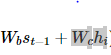

In [ ]:
max_length = 10
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
      super(BahdanauAttnDecoderRNN, self).__init__()
      
      # Define parameters
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.n_layers = n_layers
      self.dropout_p = dropout_p
      self.max_length = max_length
      
      # Define layers
      self.embedding = nn.Embedding(output_size, hidden_size)
      self.dropout = nn.Dropout(dropout_p)
      self.attn = Attn('concat', hidden_size) #attention 객체 인스턴스 생성.
      self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
      self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
      # Note: we run this one step at a time
      # TODO: FIX BATCHING
      
      # Get the embedding of the current input word (last output word), batch_size와 hidden_size vector를 하나의 vector에 다 펼친다.sequence는 어차피 1이다.
      word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
      word_embedded = self.dropout(word_embedded) #dropout한다는 것은 batch_data 중 몇 개의 데이터를 0으로 만들어버림, 그러면서 정보 손실은 안나게 함.
      
      # Calculate attention weights and apply to encoder outputs
      attn_weights = self.attn(last_hidden[-1], encoder_outputs) #가장 최근 hidden값과 encoder_output을 넣어서 attention_distribution을 뽑아낸다.
      context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N #attention weinght와 encoder_output을 곱한다(내적한다).
      context = context.transpose(0, 1) # 1 x B x N  
      
      # Combine embedded input word and attended context, run through RNN
      rnn_input = torch.cat((word_embedded, context), 2) #concat한 것이 input으로 들어간다. 가장 마지막 차원을 concat한다. 즉 hidden_size에 해당하는 차원을 concat.
      output, hidden = self.gru(rnn_input, last_hidden) #rnn의 output과 hidden이 출력된다.
      
      # Final output layer
      output = output.squeeze(0) # B x N #가장 앞의 차원을 제거한다.
      output = F.log_softmax(self.out(torch.cat((output, context), 1))) #output과 context를 다시 한번 concat하고 Linear layer에 넣는다. 그 이후, softmax함수를 거친다.
      
      # Return final output, hidden state, and attention weights (for visualization)
      return output, hidden, attn_weights

In [ ]:
x = torch.randn(2,3,4)

y =torch.randn(2,3,4)
x,y


(tensor([[[ 1.6870, -0.1390, -0.8479, -0.2591],
          [-0.2404,  0.2172, -1.2680, -0.3696],
          [ 0.2819,  1.3565,  0.1589, -1.2345]],
 
         [[ 0.3562, -1.2733, -0.0084,  1.4686],
          [ 0.1122, -0.4361, -0.5997, -0.0165],
          [ 0.1697, -1.3223, -0.4220, -0.1390]]]),
 tensor([[[-1.0948,  1.2315,  1.3023, -0.6356],
          [-1.8709,  1.8222,  1.2248, -0.7918],
          [ 1.4548, -0.5728,  0.2018,  0.1405]],
 
         [[ 0.5594, -1.3306, -0.3026, -1.3760],
          [-0.5164, -0.2956, -0.0842,  2.4715],
          [ 0.3681,  1.4650, -1.7649,  1.1250]]]))

In [ ]:
x[0,0]

tensor([ 1.6870, -0.1390, -0.8479, -0.2591])

In [ ]:
k = torch.Tensor(1,2,3,4)
kk = torch.Tensor(5,6,7,8)
torch.cat((k,kk,k),1)

RuntimeError: ignored

In [ ]:
x.transpose(0,1)

tensor([[ 1.5816,  0.6767,  0.1709],
        [-0.2647,  0.8851,  1.3593],
        [ 0.4607, -0.3926,  0.3454],
        [ 0.5187, -0.7891, -0.5237]])

In [ ]:
temp = x.view(1, 1, -1)
temp

tensor([[[ 1.5816, -0.2647,  0.4607,  0.5187,  0.6767,  0.8851, -0.3926,
          -0.7891,  0.1709,  1.3593,  0.3454, -0.5237]]])

In [ ]:
dropout = nn.Dropout(0.3)
temp = dropout(temp)
temp

tensor([[[ 2.2595, -0.0000,  0.6581,  0.7410,  0.9667,  1.2645, -0.0000,
          -1.1273,  0.0000,  0.0000,  0.4934, -0.7482]]])

In [ ]:
k = x.transpose(0,1)
k

tensor([[-0.1706,  1.3650],
        [-0.2605, -0.7624],
        [-1.5680,  0.9793]])

In [ ]:
#torch.cat((x, x, x), 0)
temp1 , temp2 = torch.cat((x, y), 1)
temp

tensor([ 0.4288, -0.2069,  1.5922,  1.1723,  0.0609,  0.2585])

## Training
### Defining a training iteration
- Encoder에 각 단어별로 삽입하고, output과 hidden state를 추적한다.
- Encoder의 마지막 hidden state는 Decoder의 첫번째 Hidden state가 된다. 그리고 Decoder의 첫번재 인풋은 <SOS>이며, 그 이후로는 Decoder의 매커니즘이 반복된다.

### Teacher Forcing vs. Scheduled Sampling
- Teachder forcing이나  maximum likelihood sampling은 Decoder에서 Training할 때, 예측한 target 값이 next input이 되는 것이 아닌, 실제 target label을 next input으로 주는 것이다. 이러한 방법은 네트워크를 좀 더 빨리 학습시킬 수 있으나, trained network가 잘못 사용될 때 불안정성을 보입니다.

- Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을 표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 “선택” 할 수 있지만, 번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.

PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로 Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다. 더 많이 사용하려면 teacher_forcing_ratio 를 확인하십시오.

In [ ]:
MAX_LENGTH = 10

teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0] #vector형태로 나옴. softmax함수에 넣기 전. 가장 첫번째 Sequence의 첫번째 row라는 뜻.

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

##학습
## 학습 데이터 준비
학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와 목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수입니다.

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

전체 학습 과정은 다음과 같습니다:

- 타이머 시작

- optimizers와 criterion(Lossfunction) 초기화

- 학습 쌍의 세트 생성

- 도식화를 위한 빈 손실 배열 시작

그런 다음 우리는 여러 번 train 을 호출하며 때로는 진행률 (예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    criterion = nn.NLLLoss() #Loss함수 정의. 

    for iter in range(1, n_iters + 1): 
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 결과 도식화
matplotlib로 학습 중에 저장된 손실 값 plot_losses 의 배열을 사용하여 도식화합니다.

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 평가
평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달합니다. 단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 EOS 토큰을 예측하면 거기에서 멈춥니다. 나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():   #학습하는 단계가 아니므로 no_grad.
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

학습 세트에 있는 임의의 문장을 평가하고 입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있습니다:

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


### 학습과 평가
이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을 더 쉽게 수행 할 수 있음) 실제로 네트워크를 초기화하고 학습을 시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의 경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은 네트워크를 사용할 수 있습니다. MacBook CPU에서 약 40분 후에 합리적인 결과를 얻을 것입니다.



In [ ]:
USE_CUDA = True
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = BahdanauAttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


IndexError: ignored

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

### Attention 시각화
Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다. 입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해 plt.matshow(attentions) 를 간단하게 실행할 수 있습니다. 열은 입력 단계와 행이 출력 단계입니다:

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

NameError: ignored

더 나은 보기를 위해 축과 라벨을 더하는 추가 작업을 수행합니다:

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")